In [1]:
import tensorflow as tf
from tensorflow .keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset=tf.keras.preprocessing.image_dataset_from_directory('Training',
                                                    shuffle = True,
                                                    image_size = (256,256),
                                                    batch_size=32,
                                                    )

Found 2152 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

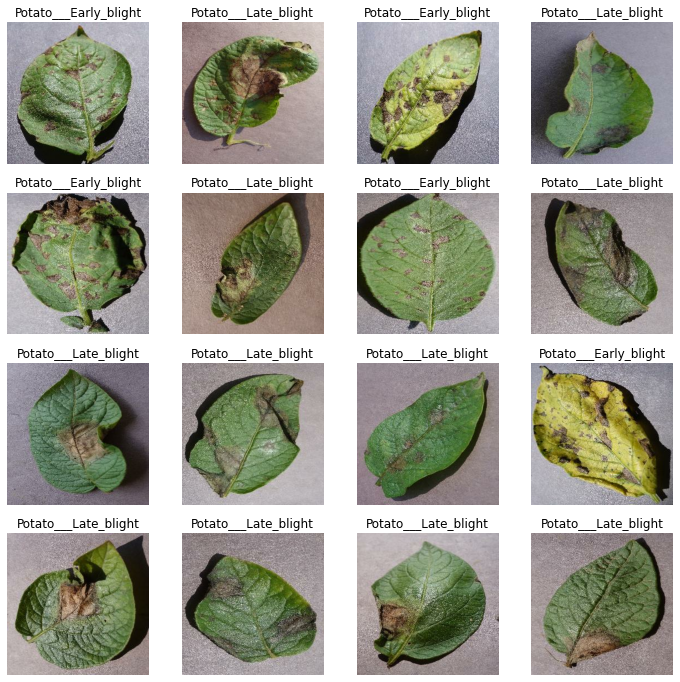

In [4]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [5]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [6]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256,256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


In [11]:
model_1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
])

model_1.build(input_shape=(32,256,256,3))

In [13]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

history_1= model_1.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
54/54 [==============================] - 67s 1s/step - loss: 0.4293 - accuracy: 0.8102 - val_loss: 0.2942 - val_accuracy: 0.8958
Epoch 2/15
54/54 [==============================] - 66s 1s/step - loss: 0.2535 - accuracy: 0.8912 - val_loss: 0.2057 - val_accuracy: 0.9010
Epoch 3/15
54/54 [==============================] - 66s 1s/step - loss: 0.1759 - accuracy: 0.9259 - val_loss: 0.1501 - val_accuracy: 0.9635
Epoch 4/15
54/54 [==============================] - 65s 1s/step - loss: 0.1570 - accuracy: 0.9433 - val_loss: 0.1433 - val_accuracy: 0.9688
Epoch 5/15
54/54 [==============================] - 66s 1s/step - loss: 0.1155 - accuracy: 0.9549 - val_loss: 0.1057 - val_accuracy: 0.9531
Epoch 6/15
54/54 [==============================] - 65s 1s/step - loss: 0.1204 - accuracy: 0.9531 - val_loss: 0.1058 - val_accuracy: 0.9635
Epoch 7/15
54/54 [==============================] - 66s 1s/step - loss: 0.1015 - accuracy: 0.9589 - val_loss: 0.0780 - val_accuracy: 0.9844
Epoch 8/15
54/54 [==

In [14]:
scores = model_1.evaluate(test_ds)

8/8 [==============================] - 3s 248ms/step - loss: 0.0068 - accuracy: 0.9961


In [15]:
def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

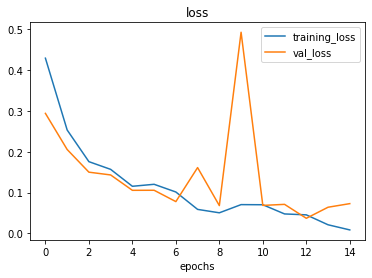

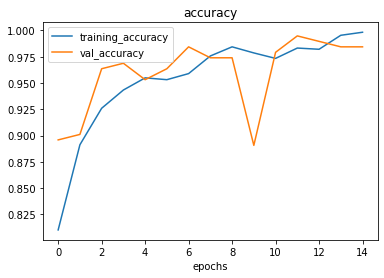

In [16]:
plot_loss_curves(history_1)

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 4s 4s/step
predicted label: Potato___Early_blight


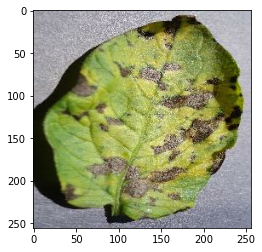

In [17]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model_1.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [18]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 21ms/step


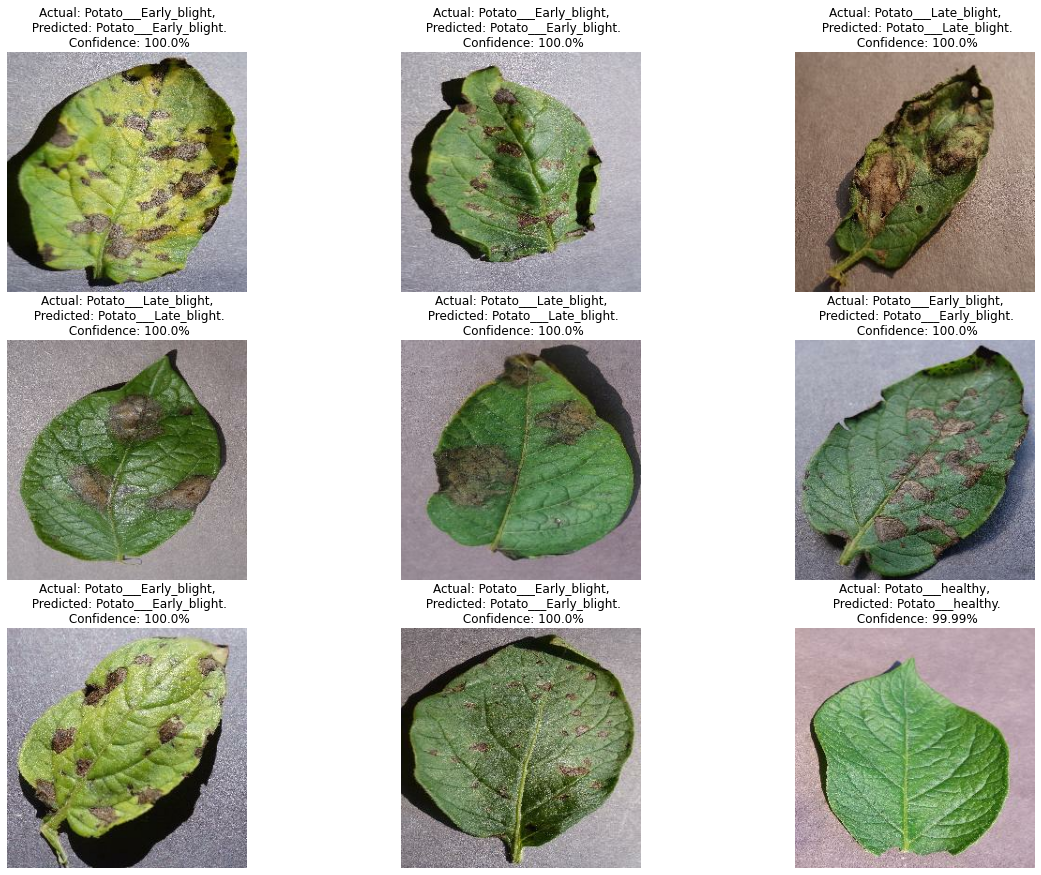

In [19]:
plt.figure(figsize=(20, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model_1, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [22]:
model_version = 1
model_1.save(f"/Potato Dieases/model/{model_version}")

INFO:tensorflow:Assets written to: /Potato Dieases/model/1\assets


INFO:tensorflow:Assets written to: /Potato Dieases/model/1\assets
